In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


CSV file found at cat_breeds.csv
Images folder found at CatBreedsRefined-7k
CSV Data Head:
                 name           length                    origin  \
0          Abyssinian  12 to 16 inches            Southeast Asia   
1              Aegean           Medium                    Greece   
2    American Bobtail           Medium  United States and Canada   
3  American Shorthair  12 to 15 inches             United States   
4   American Wirehair  Medium to large             United States   

   min_life_expectancy  max_life_expectancy  min_weight  max_weight  \
0                  9.0                 15.0         6.0        10.0   
1                  9.0                 10.0         7.0        10.0   
2                 11.0                 15.0         8.0        13.0   
3                 15.0                 20.0         7.0        12.0   
4                 14.0                 18.0         8.0        15.0   

   family_friendly  shedding  general_health  playfulness  children_frien

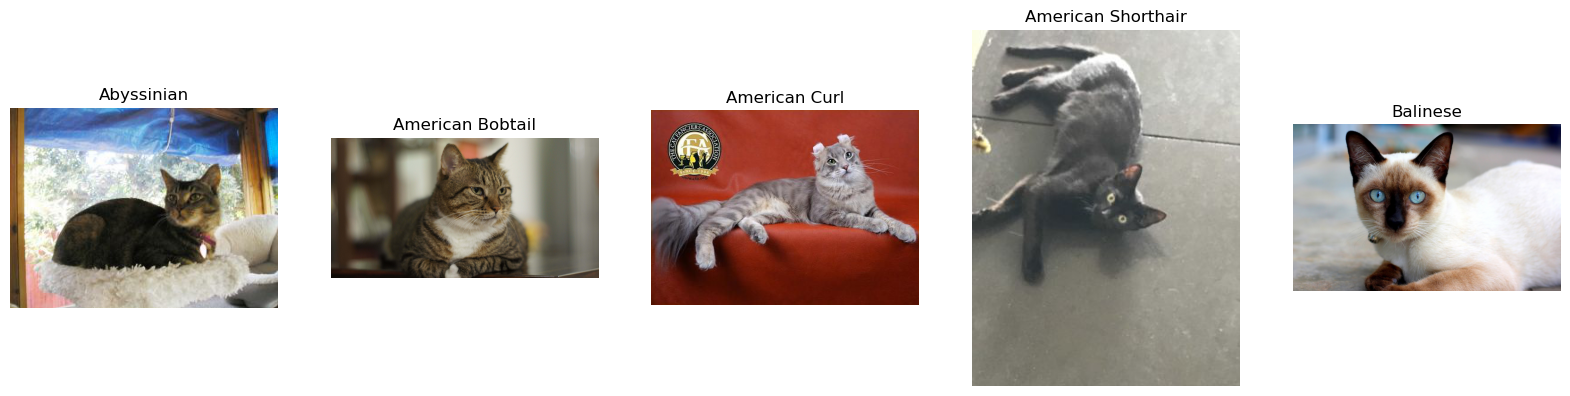

In [5]:
#load the datasets
csvpath = "cat_breeds.csv"
imagepath = "CatBreedsRefined-7k" 

#check if the dataset exists
if not os.path.exists(csvpath):
    print(f"error: csv file not found {csvpath}")
else:
    print(f"csv file at {csvpath}")

#check if the images folder exists
if not os.path.exists(imagepath):
    print(f"error: Images folder not found {imagepath}")
else:
    print(f"images folder at {imagepath}")

#load the data into a pandas dataframe
data = pd.read_csv(csvpath)
print("csv data:")
print(data.head())

#filter the data to only include the columns we need
fliterdata = data[["name", "length", "children_friendly", "general_health"]]
#set the name as the index
fliterdata.set_index("name", inplace=True)
print("filtered csv data:")
#display the first 5 rows
print(fliterdata.head())

#get the list of the breeds of cats from the image folder
breedsofcats = os.listdir(imagepath)
#display the breeds of cats
print("loaded breeds:", breedsofcats)

#fliter the data to only include the breeds of cats that are in the image folder
availablebreeds = set(breedsofcats)
fliterdata = fliterdata.loc[fliterdata.index.intersection(availablebreeds)]

#identify the breeds that are in the csv but not in the image
breedsthataremissing = set(fliterdata.index) - availablebreeds
if breedsthataremissing:
    print(f"breeds that are in csv but not dataset: {breedsthataremissing}")

#display a sample image for each breed in the dataset
#display the first 5 breeds
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, breed in enumerate(breedsofcats[:5]):
    breedfolders = os.path.join(imagepath, breed)
    imgsample = os.listdir(breedfolders)[0]
    img = plt.imread(os.path.join(breedfolders, imgsample))
    axes[i].imshow(img)
    axes[i].set_title(breed)
    axes[i].axis("off")
plt.show()



In [27]:
#create an imagdata generator with a rescale and validate split
imgdatagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#generate the training and validation datasets
training = imgdatagenerator.flow_from_directory(
    imagepath,
    #resize the images to 224x224
    target_size=(224, 224),
    #number of images to process at a time
    batch_size=32,
    #set the class mode to categorical
    class_mode="categorical",
    #set the subset to training
    subset="training"
)

validation = imgdatagenerator.flow_from_directory(
    imagepath,
    #resize the images to 224x224
    target_size=(224, 224),
    #number of images to process at a time
    batch_size=16,
    #set the class mode to categorical
    class_mode="categorical",
    #set the subset to validation
    subset="validation"
)

#map the breed names to the indices and then the indices to the breed names
classindex = training.class_indices
breedtoindex = {v: k for k, v in classindex.items()}
#filter the data to only include the breeds that are in the class indices
fliterdata = fliterdata.loc[fliterdata.index.intersection(set(breedtoindex.values()))]

Found 5600 images belonging to 42 classes.
Found 1400 images belonging to 42 classes.


In [28]:
#load the pre-trained model
pretrainedmodel = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

#freeze the layers in the base model
for layer in pretrainedmodel.layers:
    layer.trainable = False

#flatten the output of the base model 
x = Flatten()(pretrainedmodel.output)
#add a dense layer with 128 neurons and relu activation
x = Dense(128, activation="relu")(x)
#add a softmax activation with 128 for multi-class classification
#number of neurons is the same as the number of cat breeds
output = Dense(len(classindex), activation="softmax")(x)

#defining the model
model = Model(inputs=pretrainedmodel.input, outputs=output)
#compile the model with the adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

#a callback to stop training to prevent overfitting and save the best model
earlystopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("bestcataimodel.keras", save_best_only=True)

#train the model using the training and validation datasets and epocjs od 20
history = model.fit(
    training,
    validation_data=validation,
    epochs=20,
    callbacks=[earlystopping]
)


Epoch 1/20


c:\Users\Dylan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 1232s 7s/step - accuracy: 0.0470 - loss: 3.8470 - val_accuracy: 0.0779 - val_loss: 3.5097
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 958s 5s/step - accuracy: 0.0884 - loss: 3.4045 - val_accuracy: 0.0750 - val_loss: 3.3922
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 927s 5s/step - accuracy: 0.1040 - loss: 3.2186 - val_accuracy: 0.0979 - val_loss: 3.2805
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2607s 15s/step - accuracy: 0.1182 - loss: 3.1175 - val_accuracy: 0.1293 - val_loss: 3.2522
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 796s 5s/step - accuracy: 0.1358 - loss: 3.0659 - val_accuracy: 0.1236 - val_loss: 3.2206
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - accuracy: 0.1660 - loss: 2.9678 - val_accuracy: 0.1321 - val_loss: 3.2007
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1198s 7s/step - accuracy: 0.1736 - loss: 2.8888 - val_accuracy: 0.1350 - val_loss: 3.2041
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - accuracy: 0.1848 - loss: 2.8449 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


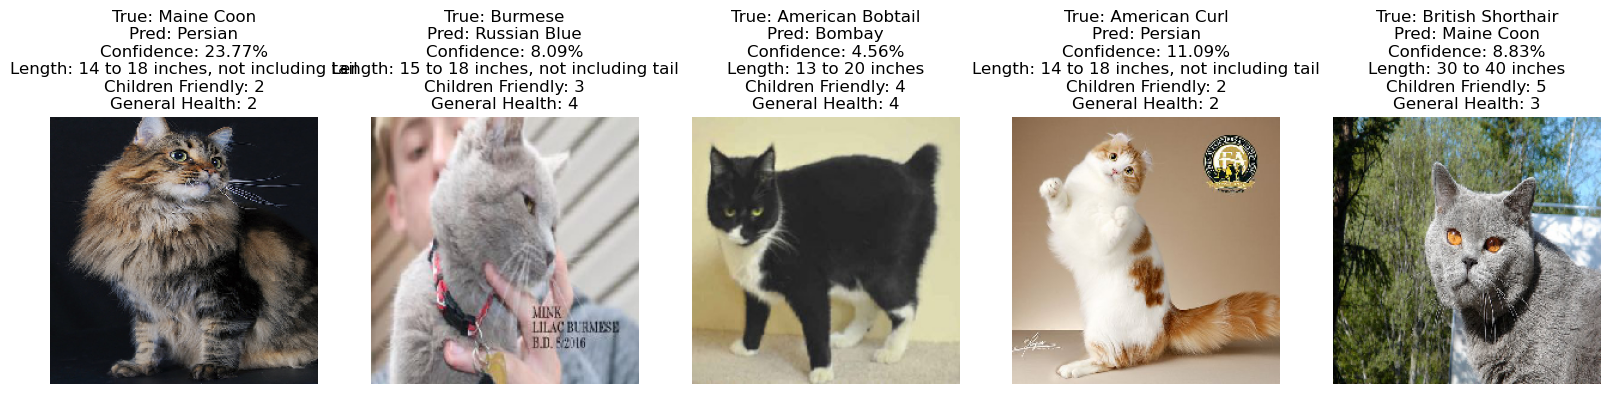

In [29]:
#get a batch of validations images and labels
validateimages, validation_labels = next(validation)
#predict the validation images with the model
predictions = model.predict(validateimages)
#convert the predictions to the class indices
predictedclasses = np.argmax(predictions, axis=1)
#convert the true labels to the class indices
trueclasses = np.argmax(validation_labels, axis=1)

#display the first 5 validation images with the true and predicted labels
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    #get the true and predicted labels using breedtoindex 
    axes[i].imshow(validateimages[i])
    rightlabel = breedtoindex[trueclasses[i]]
    predlabel = breedtoindex[predictedclasses[i]]
    #get the confidence of the prediction
    confidence = np.max(predictions[i]) * 100
    
    textfornobreedinfo = "no breed information"
    #if the breed is in the csv data, display the breed facts
    if predlabel in fliterdata.index:
        factsofbreed = fliterdata.loc[predlabel]
        textfornobreedinfo = (
            f"Length: {factsofbreed.get('length', 'Unknown')}\n"
            f"Children Friendly: {factsofbreed.get('children_friendly', 'Unknown')}\n"
            f"General Health: {factsofbreed.get('general_health', 'Unknown')}"
        )
    
    axes[i].set_title(f"True: {rightlabel}\nPred: {predlabel}\nConfidence: {confidence:.2f}%\n{textfornobreedinfo}")
    axes[i].axis("off")
plt.show()


In [30]:
#save the model to a file 
model.save('catbreedmodel.h5')
model.save('catbreedmodel1.keras')
print("Model saved as 'catbreedmodel.h5'")
print("Model saved as 'catbreedmodel1.keras'")

Model saved as 'catbreedmodel.h5'
